In [1]:
import Pkg; Pkg.activate("..")
push!(LOAD_PATH, "../src/");

In [4]:
using BenchmarkTools
using Combinatorics
using ProgressMeter
using Plots
using Random
using Santa

In [5]:
cities = read_cities("../test/cities.csv");

In [191]:
Santa.is_penalized(path::Vector{City}, i::Int) = !path[i].p && (i % 10 == 0)

function Santa.score_2opt(path::Vector{City}, k::Int, l::Int)
    @assert 1 < k < l < length(chunk.path)

    # before: a k ... l b
    # after:  a l ... k b
    a, b = k-1, l+1

    p_a   = !path[a].p && (a % 10 == 0) ? 1.1 : 1.0 # Before
    p_l_b = !path[l].p && (l % 10 == 0) ? 1.1 : 1.0 # Before
    p_k_b = !path[k].p && (l % 10 == 0) ? 1.1 : 1.0 # After

    a_k = distance(path[a], path[k]) * p_a # Before
    a_l = distance(path[a], path[l]) * p_a # After

    l_b = distance(path[l], path[b]) * p_l_b # Before
    k_b = distance(path[k], path[b]) * p_k_b # After

    diff = (a_l - a_k) + (k_b - l_b)

    # Upper bound on max penalty gain for early exit ?
    
    penalties_diff = 0.0
    
    start = (k % 10 == 0)*k
#     if start == 0
#         start = k+10-(k+chunk.offset-1) % 10
#     end
    
#     for i = start:10:l-1
#         # Some distances are computed twice...
#         penalties_diff +=
#             (!path[l+k-i].p * distance(path[l+k-i], path[l+k-i-1])) -
#             (!path[i].p * distance(path[i], path[i+1]))
#     end

    diff + penalties_diff*0.1
end

In [192]:
@benchmark score_2opt(path, 10, 118)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     69.269 ns (0.00% GC)
  median time:      69.973 ns (0.00% GC)
  mean time:        72.229 ns (2.15% GC)
  maximum time:     2.391 μs (96.83% GC)
  --------------
  samples:          10000
  evals/sample:     976

In [181]:
@benchmark score_2opt(chunk, 10, 118)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     58.814 ns (0.00% GC)
  median time:      59.111 ns (0.00% GC)
  mean time:        59.752 ns (0.00% GC)
  maximum time:     670.466 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     983

In [170]:
81e-6*200e3*30/60

8.1

In [147]:
function nn_opt(init_chunk::Chunk, K::Int)
    chunk = Chunk(copy(init_chunk.path), copy(init_chunk.offset))
    best = score(chunk.path)
    
    data = collect(vcat(map(c -> [c.x c.y], chunk.path)...)')
    kdtree = KDTree(data, reorder=false)

    # Boundaries are left untouched
    @showprogress for i = 2:length(chunk.path)-1 
        #i % 100 == 0 && print("\33[2K [$K-NN] $(i)/$(length(chunk.path)) score = $(best)\r")
        bv, bj = 0, 0
        for j in knn(kdtree, [chunk.path[i].x, chunk.path[i].y], K)[1]
            # Protect boundaries
            ((j == 1) || (j == i) || (j == length(chunk.path))) && continue
#             println(j)
            # ------------------
            # TODO: Early stopping ?
            s = score_2opt(chunk, min(i,j), max(i,j))
            if s < bv
                bv, bj = s, j
            end
        end
#         if bj != 0
#             reverse!(chunk.path,  min(i,bj), max(i,bj))
#             # println(bv)
#             best = score(chunk.path)
#         end
    end

    chunk
end

nn_opt (generic function with 1 method)

In [148]:
nn_opt(chunk, 30)

Progress:   2%|█                                        |  ETA: 0:12:38

InterruptException: InterruptException:

In [81]:
@showprogress map(c -> find_closest_cities(cities, c, 30), cities);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


In [138]:
a, b  = knn(kdtree, point, 5, true)

([180, 139763, 29507, 25353, 165649], [0.0, 11.7243, 12.224, 12.3527, 13.9233])

In [140]:
a

5-element Array{Int64,1}:
    180
 139763
  29507
  25353
 165649

In [123]:
@benchmark knn(kdtree, point, 30, true)

BenchmarkTools.Trial: 
  memory estimate:  720 bytes
  allocs estimate:  4
  --------------
  minimum time:     1.004 μs (0.00% GC)
  median time:      1.033 μs (0.00% GC)
  mean time:        1.147 μs (4.35% GC)
  maximum time:     176.131 μs (99.03% GC)
  --------------
  samples:          10000
  evals/sample:     10

In [112]:
@benchmark knn(kdtree, point, 30)

BenchmarkTools.Trial: 
  memory estimate:  720 bytes
  allocs estimate:  4
  --------------
  minimum time:     953.826 ns (0.00% GC)
  median time:      971.609 ns (0.00% GC)
  mean time:        1.084 μs (4.24% GC)
  maximum time:     78.283 μs (96.91% GC)
  --------------
  samples:          10000
  evals/sample:     23

In [59]:
@benchmark knn(kdtree, point, 30)

BenchmarkTools.Trial: 
  memory estimate:  720 bytes
  allocs estimate:  4
  --------------
  minimum time:     866.357 ns (0.00% GC)
  median time:      880.018 ns (0.00% GC)
  mean time:        926.950 ns (3.56% GC)
  maximum time:     23.370 μs (95.39% GC)
  --------------
  samples:          10000
  evals/sample:     56

In [60]:
@benchmark find_closest_cities(cities, city, 30)

BenchmarkTools.Trial: 
  memory estimate:  1.27 KiB
  allocs estimate:  6
  --------------
  minimum time:     448.119 μs (0.00% GC)
  median time:      591.045 μs (0.00% GC)
  mean time:        667.936 μs (0.00% GC)
  maximum time:     4.287 ms (0.00% GC)
  --------------
  samples:          7388
  evals/sample:     1

In [62]:
448e-6 / 866e-9

517.3210161662818

In [45]:
cities[180]

City(179, true, 894.493803147478, 1518.20907247153)

In [8]:
@benchmark score(path)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     416.640 μs (0.00% GC)
  median time:      429.277 μs (0.00% GC)
  mean time:        446.149 μs (0.00% GC)
  maximum time:     1.808 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [4]:
@benchmark score(path)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     416.726 μs (0.00% GC)
  median time:      427.940 μs (0.00% GC)
  mean time:        443.227 μs (0.00% GC)
  maximum time:     2.047 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [23]:
A = map(c -> (c.x, c.y), cities)
B = map(c -> c.p, cities);

In [9]:
@fastmath Santa.distance(a::Tuple{Float64,Float64}, b::Tuple{Float64,Float64}) = sqrt((a[1]-b[1])^2+(a[2]-b[2])^2)

In [41]:
function score2(coords::Vector{Tuple{Float64,Float64}}, primes::Vector{Bool}; start=1)
    dist = 0.0
    @inbounds for i in 1:length(path)-2
        if ((i+(start-1)) % 10 == 0) && !primes[i]
            dist += distance(coords[i], coords[i+1])*1.1
        else
            dist += distance(coords[i], coords[i+1])
        end
    end
    dist
end

score2 (generic function with 1 method)

In [49]:
@code_lowered score2(A, B)

CodeInfo(
│2 1 ─ %1 = (Main.:(#score2#40))(1, #self#, coords, primes)
│  └──      return %1
)

In [40]:
@benchmark score2(A, B)

BenchmarkTools.Trial: 
  memory estimate:  30.15 MiB
  allocs estimate:  1382337
  --------------
  minimum time:     29.154 ms (5.15% GC)
  median time:      29.568 ms (5.61% GC)
  mean time:        30.521 ms (8.29% GC)
  maximum time:     77.418 ms (58.73% GC)
  --------------
  samples:          164
  evals/sample:     1

In [11]:
function Santa.score(path::Vector{City}; start=1)
    dist = 0.0
    @inbounds for i in 1:length(path)-1
        if ((i+(start-1)) % 10 == 0) && !path[i].p
            dist += distance(path[i], path[i+1])*1.1
        else
            dist += distance(path[i], path[i+1])
        end
    end
    dist
end

In [96]:
@fastmath distance_fast(a::City, b::City) = (a.x-b.x)^2+(a.y-b.y)^2

function score_fast(path::Vector{City}; start=1)
    dist = 0.0
    @inbounds for i in 1:length(path)-1
        if ((i+(start-1)) % 10 == 0) && !path[i].p
            dist += distance_fast(path[i], path[i+1])*1.1
        else
            dist += distance_fast(path[i], path[i+1])
        end
    end
    dist
end

score_fast (generic function with 1 method)

In [36]:
@benchmark distance(cities[1], cities[2])

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  2
  --------------
  minimum time:     40.266 ns (0.00% GC)
  median time:      41.574 ns (0.00% GC)
  mean time:        57.100 ns (20.28% GC)
  maximum time:     49.045 μs (99.86% GC)
  --------------
  samples:          10000
  evals/sample:     991

In [38]:
@benchmark distance(A[1], A[2])

BenchmarkTools.Trial: 
  memory estimate:  64 bytes
  allocs estimate:  2
  --------------
  minimum time:     30.065 ns (0.00% GC)
  median time:      31.389 ns (0.00% GC)
  mean time:        42.718 ns (21.46% GC)
  maximum time:     45.233 μs (99.90% GC)
  --------------
  samples:          10000
  evals/sample:     993

In [105]:
@benchmark score(path)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     423.415 μs (0.00% GC)
  median time:      432.714 μs (0.00% GC)
  mean time:        438.342 μs (0.00% GC)
  maximum time:     902.946 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [106]:
@benchmark score_fast(path)

BenchmarkTools.Trial: 
  memory estimate:  16 bytes
  allocs estimate:  1
  --------------
  minimum time:     391.279 μs (0.00% GC)
  median time:      401.177 μs (0.00% GC)
  mean time:        406.143 μs (0.00% GC)
  maximum time:     902.564 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [14]:
@code_native score(path)

	.text
; Function score {
; Location: In[11]:2
	subq	$40, %rsp
	movabsq	$140342283044992, %rax  # imm = 0x7FA3FBED8880
	movq	%rax, 8(%rsp)
	movabsq	$140343325044272, %rax  # imm = 0x7FA43A092E30
	movq	%rax, 16(%rsp)
	movabsq	$140342283044552, %rax  # imm = 0x7FA3FBED86C8
	movq	%rax, 24(%rsp)
	movq	%rdi, 32(%rsp)
	movabsq	$jl_invoke, %rax
	movabsq	$140343350826128, %rdi  # imm = 0x7FA43B929490
	leaq	8(%rsp), %rsi
	movl	$4, %edx
	callq	*%rax
	vmovsd	(%rax), %xmm0           # xmm0 = mem[0],zero
	addq	$40, %rsp
	retq
	nop
;}


In [59]:
# k-opt


# 2-opt

# a i ... j b
# a j ... i b

# 3 0opt

# 

In [69]:
score(path)

1.5166946654302643e6

In [173]:
function solve_greedy(cities::Vector{City})
    cities = copy(cities)
    path = Vector{City}([popfirst!(cities)])
    @showprogress for _ in 1:length(cities)
        _, nn = find_closest_cities(cities, path[end], 1)[1]
        push!(path, cities[nn])
        deleteat!(cities, nn)
    end
    push!(path, path[1])
    path
end

solve_greedy (generic function with 1 method)

In [174]:
greedy_path = solve_greedy(cities)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


197770-element Array{City,1}:
 City(0, false, 316.836739061509, 2202.34070733524)     
 City(78934, false, 314.716006798186, 2193.8888357871)  
 City(111804, false, 314.494243312195, 2186.64674767296)
 City(52086, false, 308.608834287432, 2185.79795356423) 
 City(18295, false, 308.903690863706, 2178.86836182647) 
 City(134585, false, 305.515942441998, 2174.91133677109)
 City(109090, false, 305.507481154249, 2169.64027406796)
 City(37150, false, 308.411578634224, 2165.03035255425) 
 City(96442, false, 314.039635760104, 2160.98155101422) 
 City(126815, false, 319.546638178268, 2163.57421058608)
 City(122542, false, 316.15315497475, 2167.66578208334) 
 City(142366, false, 311.923519378368, 2171.76784832097)
 City(25283, false, 317.130946313904, 2173.64124165315) 
 ⋮                                                      
 City(20700, false, 466.656501721845, 87.9326740119409) 
 City(175547, false, 690.441107502875, 82.7085782034601)
 City(82101, false, 697.894937006569, 120.225552919836) 
 

In [175]:
score(greedy_path)

1.8126021861388376e6

In [176]:
length(unique(greedy_path))

197769

In [172]:
verify!(greedy_path)

In [ ]:
# A slow but generic k-opt move
function k_opt(path::Vector{City}, indices::Vector{Int})
    for p in permutations(indices)
        
    end
end

# k_opt(copy_path)

In [102]:
function score_2opt(chunk::Chunk, k::Int, l::Int)
    @assert 1 < k < l < length(chunk.path)

    # before: a k ... l b
    # after:  a l ... k b
    a, b = k-1, l+1
    
    p_a = is_penalized(chunk, a) ? 1.1 : 1.0
    p_l_b = is_penalized(chunk, l) ? 1.1 : 1.0 # Before
    p_k_b = !chunk.path[k].p && ((l+chunk.offset-1) % 10 == 0) ? 1.1 : 1.0 # After

    a_k = distance(chunk.path[a], chunk.path[k]) * p_a # Before
    a_l = distance(chunk.path[a], chunk.path[l]) * p_a # After

    l_b = distance(chunk.path[l], chunk.path[b]) * p_l_b # Before
    k_b = distance(chunk.path[k], chunk.path[b]) * p_k_b # After

    diff = (a_l - a_k) + (k_b - l_b)

    # Upper bound on max penalty gain for early exit ?
    
    penalties_diff = 0.0
    
    start = ((k+chunk.offset-1) % 10 == 0)*k
    if start == 0
        start = k+10-(k+chunk.offset-1) % 10
    end
    
    for i = start:10:l-1
        # Some distances are computed twice...
        penalties_diff -= !chunk.path[i].p * distance(chunk.path[i], chunk.path[i+1])
        penalties_diff += !chunk.path[l+k-i].p * distance(chunk.path[l+k-i], chunk.path[l+k-i-1])
    end

    penalties_diff *= 0.1
    diff + penalties_diff
end

score_2opt (generic function with 1 method)

In [138]:
function opt_3(path::Vector{City}, i::Int, j::Int, k::Int)
# "ijk"
# "ikj"
# "jik"
# "jki"
# "kij"
# "kji"
    # i -> j -> k
    a = score(path[i-1:k+1], start=i-1)
    
    # i -> k -> j
    reverse!(path, j, k)
    b = score(path[i-1:k+1], start=i-1)
    reverse!(path, j, k)
    
    # j -> i -> k
    reverse!(path, i, j)
    c = score(path[i-1:k+1], start=i-1)
    reverse!(path, i, j)
    
    # j -> k -> i
    reverse!(path, i, k)
    reverse!(path, j, k)
    d = score(path[i-1:k+1], start=i-1)
    reverse!(path, i, k)
    reverse!(path, j, k)
    
    # k -> i -> j
    reverse!(path, i, k)
    reverse!(path, i, j)
    e = score(path[i-1:k+1], start=i-1)
    reverse!(path, i, k)
    reverse!(path, i, j)
    
    # k -> j -> i
    reverse!(path, i, k)
    f = score(path[i-1:k+1], start=i-1)
    reverse!(path, i, k)
    
    println(b-a, " ", c-a, " ", d-a, " ", e-a, " ", f-a)
end

opt_3 (generic function with 1 method)

In [139]:
chunk = Chunk(path, 1);
score(chunk)

1.5166946654302643e6

In [145]:
@time opt_3(path, 4, 8, 25)

1.5604685613872675 -6.82328289849778 13.661327160380097 5.2833614099840815 22.413352123420566
  0.000247 seconds (336 allocations: 12.875 KiB)


In [110]:
score_2opt(chunk, 8, 25)

44.445107597701416

In [100]:
z = copy(path)
@time opt_3(z, 10, 20, 30)

  0.000004 seconds (6 allocations: 1.047 KiB)


142.263292581572

In [71]:
collect(permutations([10, 20, 30]))

6-element Array{Array{Int64,1},1}:
 [10, 20, 30]
 [10, 30, 20]
 [20, 10, 30]
 [20, 30, 10]
 [30, 10, 20]
 [30, 20, 10]

In [101]:
collect(permutations(["i", "j", "k"]))

6-element Array{Array{String,1},1}:
 ["i", "j", "k"]
 ["i", "k", "j"]
 ["j", "i", "k"]
 ["j", "k", "i"]
 ["k", "i", "j"]
 ["k", "j", "i"]

In [61]:
factorial(3)

6

In [56]:
function perm_opt(init_chunk::Chunk, Δ::Int)
    chunk = Chunk(copy(init_chunk.path), copy(init_chunk.offset))

    @showprogress for i = Δ+2:length(chunk.path)-(Δ+2)
        best, perm = score(chunk.path[i-Δ-1:i+Δ+1], start=(chunk.offset-1)+(i-Δ-1)), []
        for j in permutations(i-Δ:i+Δ)
            s = score(vcat(chunk.path[i-Δ-1], chunk.path[j], chunk.path[i+Δ+1]), start=(chunk.offset-1)+(i-Δ-1))
            if s < best
                best, perm = s, j
            end
        end
        if perm != []
            chunk.path[i-Δ:i+Δ] = chunk.path[perm]
            println(score(chunk))
        end
    end

    chunk
end

perm_opt (generic function with 1 method)

In [58]:
new_chunk = perm_opt(Chunk(path[20000:end], 20000), 1) # TODO: With 3 (or 4 in // ?)

1.3675097941974984e6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Chunk(City[City(164121, false, 824.933, 2265.62), City(23409, false, 827.457, 2274.21), City(83003, true, 826.912, 2284.19), City(171577, false, 834.177, 2284.1), City(15594, false, 841.447, 2283.82), City(154326, false, 848.827, 2281.19), City(51841, false, 856.566, 2275.98), City(117940, false, 865.938, 2279.8), City(144365, false, 870.311, 2286.53), City(1171, true, 877.56, 2289.67)  …  City(47239, false, 314.748, 2210.93), City(177242, false, 305.86, 2211.7), City(167366, false, 298.953, 2206.54), City(38941, false, 292.125, 2202.62), City(22121, false, 286.761, 2196.7), City(153911, true, 290.865, 2191.07), City(75405, false, 297.672, 2193.0), City(40230, false, 305.186, 2192.46), City(48816, false, 306.733, 2200.74), City(0, false, 316.837, 2202.34)], 20000)

In [26]:
new_path = full_perm_opt(path, 1) # TODO: With 3 (or 4 in // ?)

Progress:  89%|█████████████████████████████████████    |  ETA: 0:00:00

1.5166946619556383e6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


197770-element Array{City,1}:
 City(0, false, 316.836739061509, 2202.34070733524)     
 City(78934, false, 314.716006798186, 2193.8888357871)  
 City(111804, false, 314.494243312195, 2186.64674767296)
 City(69414, false, 320.997523957835, 2186.42278175365) 
 City(2187, false, 326.961985267161, 2181.98346864998)  
 City(177800, false, 330.044926325094, 2177.75218902023)
 City(95592, false, 335.221382881878, 2175.77170748142) 
 City(59996, false, 331.363834974152, 2170.21985134593) 
 City(14587, false, 324.965464561135, 2166.50341935467) 
 City(22880, false, 323.541435012613, 2172.48684781406) 
 City(117533, false, 321.321753628987, 2178.58944816756)
 City(5333, true, 315.092520044541, 2179.84653261954)   
 City(25283, false, 317.130946313904, 2173.64124165315) 
 ⋮                                                      
 City(29922, false, 320.129111731197, 2220.60539395666) 
 City(137367, false, 324.443240482392, 2209.76354995075)
 City(47239, false, 314.747999752136, 2210.93335480383) 
 

In [12]:
out = vcat("Path", map(c -> c.i, new_path))
write("sub_perm_opt_$(score(new_path)).csv", join(out, "\n"))

1273279

In [84]:
function perm_opt(init_path::Vector{City}, z::Int)
    path = copy(init_path)
    @showprogress for i = 10:10:length(path)-5
        best, perm = score(path[i-z-1:i+z+1], start=i-z-1), []
        for j in permutations(i-z:i+z)
            s = score(vcat(path[i-z-1], path[j], path[i+z+1]), start=i-z-1)
            if s < best
                best = s
                perm = j
            end
        end
        if perm != []
            path[i-z:i+z] = path[perm]
            println(score(path))
        end
    end
    path
end

perm_opt (generic function with 1 method)

In [86]:
new_path = perm_opt(path, 3)

Progress:  99%|████████████████████████████████████████ |  ETA: 0:00:04

1.5166976437012164e6
1.5166967623374437e6
1.5166966923430273e6
1.5166966138366598e6
1.516696317820774e6
1.5166961948724783e6
1.5166959717528464e6
1.5166958013895995e6
1.5166957862940321e6
1.5166956160193223e6
1.5166955359360967e6
1.5166955306699323e6
1.5166951086941673e6
1.5166950960153998e6
1.516694770092221e6
1.5166946895237362e6
1.516694666836447e6
1.5166946654302643e6


Progress: 100%|█████████████████████████████████████████| Time: 0:04:14


197770-element Array{City,1}:
 City(0, false, 316.836739061509, 2202.34070733524)     
 City(78934, false, 314.716006798186, 2193.8888357871)  
 City(111804, false, 314.494243312195, 2186.64674767296)
 City(69414, false, 320.997523957835, 2186.42278175365) 
 City(2187, false, 326.961985267161, 2181.98346864998)  
 City(177800, false, 330.044926325094, 2177.75218902023)
 City(95592, false, 335.221382881878, 2175.77170748142) 
 City(59996, false, 331.363834974152, 2170.21985134593) 
 City(14587, false, 324.965464561135, 2166.50341935467) 
 City(22880, false, 323.541435012613, 2172.48684781406) 
 City(117533, false, 321.321753628987, 2178.58944816756)
 City(5333, true, 315.092520044541, 2179.84653261954)   
 City(25283, false, 317.130946313904, 2173.64124165315) 
 ⋮                                                      
 City(29922, false, 320.129111731197, 2220.60539395666) 
 City(137367, false, 324.443240482392, 2209.76354995075)
 City(47239, false, 314.747999752136, 2210.93335480383) 
 

In [88]:
out = vcat("Path", map(c -> c.i, new_path))
write("sub_perm_opt_$(score(new_path)).csv", join(out, "\n"))

1273279

In [79]:
# @showprogress for i = 10:10:length(path)-5
#     z = 3
#     best, perm = score(path[i-z-1:i+z+1], start=i-z-1), []
#     for j in permutations(i-z:i+z)
#         s = score(vcat(path[i-z-1], path[j], path[i+z+1]), start=i-z-1)
#         if s < best
#             best = s
#             perm = j
#         end
#     end
#     if perm != []
#         path[i-z:i+z] = path[perm]
#         println(score(path))
#     end
# end

Progress:   6%|███                                      |  ETA: 0:06:32

1.5166958767621508e6


Progress:   7%|███                                      |  ETA: 0:06:30

InterruptException: InterruptException:

In [78]:
factorial(7)

5040

In [30]:
i = 10
collect(permutations(i-2:i+2))

120-element Array{Array{Int64,1},1}:
 [8, 9, 10, 11, 12]
 [8, 9, 10, 12, 11]
 [8, 9, 11, 10, 12]
 [8, 9, 11, 12, 10]
 [8, 9, 12, 10, 11]
 [8, 9, 12, 11, 10]
 [8, 10, 9, 11, 12]
 [8, 10, 9, 12, 11]
 [8, 10, 11, 9, 12]
 [8, 10, 11, 12, 9]
 [8, 10, 12, 9, 11]
 [8, 10, 12, 11, 9]
 [8, 11, 9, 10, 12]
 ⋮                 
 [12, 10, 8, 9, 11]
 [12, 10, 8, 11, 9]
 [12, 10, 9, 8, 11]
 [12, 10, 9, 11, 8]
 [12, 10, 11, 8, 9]
 [12, 10, 11, 9, 8]
 [12, 11, 8, 9, 10]
 [12, 11, 8, 10, 9]
 [12, 11, 9, 8, 10]
 [12, 11, 9, 10, 8]
 [12, 11, 10, 8, 9]
 [12, 11, 10, 9, 8]

In [25]:
# Score the swapping reversal of the path from k (inclusive) to l (inclusive)
# The lower the better
function score_2opt(chunk::Chunk, k::Int, l::Int)
    @assert 1 < k < l < length(chunk.path)

    # before: a k ... l b
    # after:  a l ... k b
    a, b = k-1, l+1
    
    p_a = is_penalized(chunk, a) ? 1.1 : 1.0
    p_l_b = is_penalized(chunk, l) ? 1.1 : 1.0 # Before
    p_k_b = !chunk.path[k].p && ((l+chunk.offset-1) % 10 == 0) ? 1.1 : 1.0 # After

    a_k = distance(chunk.path[a], chunk.path[k]) * p_a # Before
    a_l = distance(chunk.path[a], chunk.path[l]) * p_a # After

    l_b = distance(chunk.path[l], chunk.path[b]) * p_l_b # Before
    k_b = distance(chunk.path[k], chunk.path[b]) * p_k_b # After

    diff = (a_l - a_k) + (k_b - l_b)

    # Upper bound on max penalty gain for early exit ?
    
    penalties_diff = 0.0
    
    start = (k%10 == 0)*k
    if start == 0
        start = k+10-(k+chunk.offset-1) % 10
    end
    
    for i = start:10:l-1
        # Some distances are computed twice...
        penalties_diff -= !chunk.path[i].p * distance(chunk.path[i], chunk.path[i+1])
        penalties_diff += !chunk.path[l+k-i].p * distance(chunk.path[l+k-i], chunk.path[l+k-i-1])
    end

    penalties_diff *= 0.1
    diff + penalties_diff
end

score_2opt (generic function with 1 method)

In [26]:
let
    k, l = 1739, 1751
    a, b = k-1, l+1
    c1 = Chunk(path[1:10000], 1)
    c2 = Chunk(reverse(path[1:10000], k, l), 1)
    println(score(c2) - score(c1))
    println(score_2opt(c1, k, l))
    @benchmark score_2opt($c1, 21, 2100)
end

19.641401590954047
19.64140159094602


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     665.000 ns (0.00% GC)
  median time:      667.937 ns (0.00% GC)
  mean time:        675.936 ns (0.00% GC)
  maximum time:     8.808 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     159

In [24]:
let
    k, l = 1739, 1751
    a, b = k-1, l+1
    c1 = Chunk(path[1:10000], 1)
    c2 = Chunk(reverse(path[1:10000], k, l), 1)
    println(score(c2) - score(c1))
    println(score_2opt(c1, k, l))
    @benchmark score_2opt($c1, 21, 2100)
end

19.641401590954047
19.64140159094602


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     664.658 ns (0.00% GC)
  median time:      665.146 ns (0.00% GC)
  mean time:        674.386 ns (0.00% GC)
  maximum time:     1.537 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     158

In [12]:
function nn_opt_v2(init_chunk::Chunk, K::Int)
    chunk = Chunk(copy(init_chunk.path), copy(init_chunk.offset))

    # Boundaries are left untouched
    @showprogress for i = 2:length(chunk.path)-1 
        # i % 1000 == 0 && println("$(i)/$(length(path))")
        bv, bj = 0, 0
        for (_, j) in find_closest_cities(chunk.path, chunk.path[i], K)
            # Protect boundaries
            ((j == 1) || (j == length(chunk.path))) && continue
            # ------------------
            s = score_2opt(chunk, min(i,j), max(i,j))
            if s < bv
                bv, bj = s, j
            end
        end
        if bj != 0
            reverse!(chunk.path,  min(i,bj), max(i,bj))
            println(bv)
            println(score(chunk.path))
        end
    end
    path
end

nn_opt_v2 (generic function with 1 method)

In [13]:
chunk = Chunk(path, 1)

Chunk(City[City(0, false, 316.837, 2202.34), City(78934, false, 314.716, 2193.89), City(111804, false, 314.494, 2186.65), City(69414, false, 320.998, 2186.42), City(2187, false, 326.962, 2181.98), City(177800, false, 330.045, 2177.75), City(95592, false, 335.221, 2175.77), City(59996, false, 331.364, 2170.22), City(14587, false, 324.965, 2166.5), City(22880, false, 323.541, 2172.49)  …  City(47239, false, 314.748, 2210.93), City(177242, false, 305.86, 2211.7), City(167366, false, 298.953, 2206.54), City(38941, false, 292.125, 2202.62), City(22121, false, 286.761, 2196.7), City(153911, true, 290.865, 2191.07), City(75405, false, 297.672, 2193.0), City(40230, false, 305.186, 2192.46), City(48816, false, 306.733, 2200.74), City(0, false, 316.837, 2202.34)], 1)

In [15]:
nn_opt_v2(chunk, 300)

Progress:   0%|                                         |  ETA: 1:41:43

-0.7400889633419094
1.5169171596412554e6


Progress:   0%|                                         |  ETA: 0:44:40

-0.24324807858425235
1.516916916393177e6


Progress:   1%|                                         |  ETA: 0:27:48

-18.181945276376243
1.516898734447902e6


Progress:   4%|██                                       |  ETA: 0:09:55

-0.15741352534614972
1.5168985770343766e6


Progress:   5%|██                                       |  ETA: 0:08:42

-0.586078049182869
1.5168979909563272e6


Progress:   5%|██                                       |  ETA: 0:08:25

-0.5807721453854803
1.516897410184182e6


Progress:  10%|████                                     |  ETA: 0:09:46

-0.8244782985903454
1.516896585705883e6


Progress:  10%|████                                     |  ETA: 0:09:48

-1.3062833250975836
1.5168952794225581e6


Progress:  11%|████                                     |  ETA: 0:10:35

-1.846279687977622
1.5168934331428702e6


Progress:  12%|█████                                    |  ETA: 0:10:57

-0.13858230516863124
1.5168932945605651e6
-6.873379665652456
1.5168864211808988e6


Progress:  13%|█████                                    |  ETA: 0:10:09

-0.27656312605996813
1.516886144617773e6


Progress:  16%|███████                                  |  ETA: 0:09:31

-1.759747610565129
1.516884384870162e6


Progress:  16%|███████                                  |  ETA: 0:09:29

-1.9376341135957262
1.5168824472360492e6


Progress:  16%|███████                                  |  ETA: 0:09:27

-0.4527454112082321
1.5168819944906381e6
-0.7995144383635671
1.5168811949762e6


Progress:  17%|███████                                  |  ETA: 0:09:10

-2.6507840508210414
1.5168785441921498e6


Progress:  17%|███████                                  |  ETA: 0:09:02

-1.016490806159263
1.5168775277013439e6


Progress:  18%|███████                                  |  ETA: 0:08:48

-0.7510049164966173
1.5168767766964268e6


Progress:  18%|███████                                  |  ETA: 0:08:44

-0.5968048242769992
1.516876179891602e6


Progress:  18%|███████                                  |  ETA: 0:08:41

-0.40404100239008733
1.5168757758506003e6


Progress:  18%|████████                                 |  ETA: 0:08:37

-1.53156768761433
1.5168742442829118e6


Progress:  20%|████████                                 |  ETA: 0:08:07

-0.04863511149025257
1.5168741956478008e6


Progress:  20%|████████                                 |  ETA: 0:08:00

-0.4333979208454941
1.5168737622498793e6


Progress:  20%|████████                                 |  ETA: 0:07:59

-0.25342799794822113
1.5168735088218816e6


Progress:  21%|█████████                                |  ETA: 0:07:45

-1.5652458124885822
1.5168719435760693e6


Progress:  27%|███████████                              |  ETA: 0:06:42

-2.346099915332145
1.5168695974761562e6


Progress:  27%|███████████                              |  ETA: 0:06:42

-2.276658226706607
1.516867320817932e6
-5.001295840141746
1.5168623195220882e6


Progress:  28%|████████████                             |  ETA: 0:06:29

-1.7817941972163096
1.5168605377278903e6


Progress:  29%|████████████                             |  ETA: 0:06:25

-0.8552734110822864
1.516859682454479e6


Progress:  29%|████████████                             |  ETA: 0:06:25

-0.9521493871665605
1.516858730305092e6
-0.5177438313521497
1.5168582125612604e6


Progress:  29%|████████████                             |  ETA: 0:06:25

-1.6636820329732385
1.5168565488792278e6


Progress:  29%|████████████                             |  ETA: 0:06:23

-1.4520155480697028
1.5168550968636794e6


Progress:  32%|█████████████                            |  ETA: 0:06:04

-0.6670094348856717
1.5168544298542445e6


Progress:  33%|█████████████                            |  ETA: 0:05:58

-1.1826091979983535
1.5168532472450458e6


Progress:  33%|█████████████                            |  ETA: 0:05:57

-3.2603622890635138
1.516849986882757e6


Progress:  34%|██████████████                           |  ETA: 0:05:47

-0.024283920762494304
1.5168499625988363e6


Progress:  34%|██████████████                           |  ETA: 0:05:46

-0.8638225155063828
1.5168490987763214e6


Progress:  35%|██████████████                           |  ETA: 0:05:39

-1.3037458193374944
1.516847795030502e6


Progress:  38%|███████████████                          |  ETA: 0:05:21

-2.1703872901272527
1.5168456246432113e6


Progress:  38%|███████████████                          |  ETA: 0:05:20

-0.47246810577349985
1.5168451521751052e6
-0.14581682827895098
1.5168450063582773e6


Progress:  38%|████████████████                         |  ETA: 0:05:18

-3.408805099357978
1.5168415975531782e6


Progress:  38%|████████████████                         |  ETA: 0:05:16

-0.04881021039107303
1.516841548742968e6


Progress:  39%|████████████████                         |  ETA: 0:05:13

-0.1630240260575393
1.516841385718942e6


Progress:  40%|████████████████                         |  ETA: 0:05:09

-2.2759282192552623
1.5168391097907212e6


Progress:  41%|█████████████████                        |  ETA: 0:05:00

-0.1155703350052315
1.5168389942203865e6


Progress:  45%|██████████████████                       |  ETA: 0:04:36

-2.2247712539453017
1.5168367694491325e6


Progress:  45%|███████████████████                      |  ETA: 0:04:32

-0.6570004461966921
1.5168361124486863e6


Progress:  48%|███████████████████                      |  ETA: 0:04:21

-0.7279205167766243
1.516835384528169e6


Progress:  48%|███████████████████                      |  ETA: 0:04:21

-2.2926042188643523
1.516833091923951e6


Progress:  49%|████████████████████                     |  ETA: 0:04:12

-0.6795000131732003
1.5168324124239397e6
-5.508293617384281
1.5168269041303224e6
-5.917392237483092
1.516820986738083e6


Progress:  49%|████████████████████                     |  ETA: 0:04:07

-1.7511114249017545
1.5168192356266591e6


Progress:  49%|████████████████████                     |  ETA: 0:04:07

-1.6807983695155166
1.5168175548282883e6


Progress:  53%|██████████████████████                   |  ETA: 0:03:42

-1.1414228695982045
1.5168164134054198e6


Progress:  53%|██████████████████████                   |  ETA: 0:03:41

-1.7203062894528536
1.5168146930991323e6


Progress:  54%|██████████████████████                   |  ETA: 0:03:39

-0.45563448811611096
1.516814237464644e6


Progress:  54%|██████████████████████                   |  ETA: 0:03:35

-4.40405826724921
1.5168098334063776e6


Progress:  57%|███████████████████████                  |  ETA: 0:03:23

-0.8666948738414968
1.5168089667115037e6


Progress:  57%|███████████████████████                  |  ETA: 0:03:23

-1.1093051952291315
1.5168078574063084e6


Progress:  58%|████████████████████████                 |  ETA: 0:03:19

-0.6714066380945387
1.5168071859996708e6
-1.2507649048291287
1.5168059352347655e6


Progress:  60%|████████████████████████                 |  ETA: 0:03:12

-0.8355964164938925
1.5168050996383475e6


Progress:  60%|█████████████████████████                |  ETA: 0:03:11

-0.02071957467265273
1.5168050789187734e6


Progress:  60%|█████████████████████████                |  ETA: 0:03:10

-0.211170446874408
1.516804867748326e6


Progress:  61%|█████████████████████████                |  ETA: 0:03:02

-0.3847849949352349
1.516804482963332e6


Progress:  61%|█████████████████████████                |  ETA: 0:03:01

-2.434893396652921
1.5168020480699374e6


Progress:  62%|█████████████████████████                |  ETA: 0:02:59

-1.8207826122823443
1.516800227287325e6
-2.962332021531066
1.5167972649553036e6


Progress:  66%|███████████████████████████              |  ETA: 0:02:39

-4.247553531459074
1.5167930174017695e6


Progress:  66%|███████████████████████████              |  ETA: 0:02:37

-1.923455857817685
1.516791093945914e6


Progress:  67%|███████████████████████████              |  ETA: 0:02:34

-0.846253149322429
1.5167902476927657e6


Progress:  67%|███████████████████████████              |  ETA: 0:02:33

-0.24946941587946656
1.5167899982233492e6


Progress:  67%|███████████████████████████              |  ETA: 0:02:33

-2.5690597635453885
1.5167874291635856e6


Progress:  67%|████████████████████████████             |  ETA: 0:02:31

-0.07942629619281671
1.5167873497372896e6


Progress:  68%|████████████████████████████             |  ETA: 0:02:25

-1.326561923282818
1.5167860231753665e6


Progress:  70%|█████████████████████████████            |  ETA: 0:02:19

-0.10469954278808213
1.5167859184758249e6


Progress:  70%|█████████████████████████████            |  ETA: 0:02:16

-0.849793688776904
1.5167850686821372e6


Progress:  71%|█████████████████████████████            |  ETA: 0:02:12

-0.012239343861412344
1.5167850564427932e6


Progress:  72%|█████████████████████████████            |  ETA: 0:02:08

-0.04438091572620184
1.5167850120618776e6


Progress:  75%|███████████████████████████████          |  ETA: 0:01:57

-0.16713287978426872
1.5167848449289978e6


Progress:  79%|████████████████████████████████         |  ETA: 0:01:38

-1.8506645035072102
1.516782994264495e6


Progress:  79%|████████████████████████████████         |  ETA: 0:01:36

-2.231426309255437
1.516780762838186e6
-

Progress:  79%|████████████████████████████████         |  ETA: 0:01:36

0.935047866494068
1.5167798277903197e6


Progress:  79%|████████████████████████████████         |  ETA: 0:01:35

-2.3017560818979597
1.516777526034237e6
-0.02650570523933493
1.5167774995285338e6
-0.7449223232624744
1.5167767546062106e6
-2.3405087944084086
1.5167744140974162e6
-2.982824942113348
1.5167714312724741e6


Progress:  82%|██████████████████████████████████       |  ETA: 0:01:21

-0.3216491704673703
1.5167711096233036e6


Progress:  82%|██████████████████████████████████       |  ETA: 0:01:20

-0.016634524851642518
1.5167710929887788e6


Progress:  84%|██████████████████████████████████       |  ETA: 0:01:13

-0.4614153970371744
1.5167706315733811e6


Progress:  85%|███████████████████████████████████      |  ETA: 0:01:05

-10.01060686603315
1.5167606209665244e6
-3.623627778710894
1.5167569973387432e6
-4.007065585352701
1.5167529902731578e6


Progress:  87%|████████████████████████████████████     |  ETA: 0:00:59

-0.3302893173121797
1.516752659983841e6


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:51

-1.0613182605718734
1.5167515986655834e6


Progress:  89%|█████████████████████████████████████    |  ETA: 0:00:46

-0.1603720856026607
1.5167514382934987e6


Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:36

-0.4511019784199273
1.5167509871915206e6


Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:33

-0.2908907420557869
1.5167506963007785e6


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:32

-0.8155918627452667
1.5167498807089166e6
-3.4599957140794038
1.5167464207132016e6
-0.7209185526315389
1.516745699794649e6


Progress:  96%|████████████████████████████████████████ |  ETA: 0:00:15

-1.9330837070807916
1.5167437667109407e6


Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:10

-0.5046410010691558
1.5167432620699385e6
-0.6806567346007899
1.516742581413206e6


Progress:  99%|████████████████████████████████████████ |  ETA: 0:00:06

-2.529678444662639
1.516740051734761e6


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:03

-0.1433832059622695
1.516739908351555e6


Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:03

-1.5204348055096866
1.516738387916749e6


Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:02

-1.847833313256632
1.5167365400834356e6
-9.171202890627983
1.5167273688805453e6


Progress: 100%|█████████████████████████████████████████| Time: 0:08:07


197770-element Array{City,1}:
 City(0, false, 316.836739061509, 2202.34070733524)     
 City(78934, false, 314.716006798186, 2193.8888357871)  
 City(111804, false, 314.494243312195, 2186.64674767296)
 City(69414, false, 320.997523957835, 2186.42278175365) 
 City(2187, false, 326.961985267161, 2181.98346864998)  
 City(177800, false, 330.044926325094, 2177.75218902023)
 City(95592, false, 335.221382881878, 2175.77170748142) 
 City(59996, false, 331.363834974152, 2170.21985134593) 
 City(14587, false, 324.965464561135, 2166.50341935467) 
 City(22880, false, 323.541435012613, 2172.48684781406) 
 City(117533, false, 321.321753628987, 2178.58944816756)
 City(5333, true, 315.092520044541, 2179.84653261954)   
 City(25283, false, 317.130946313904, 2173.64124165315) 
 ⋮                                                      
 City(29922, false, 320.129111731197, 2220.60539395666) 
 City(137367, false, 324.443240482392, 2209.76354995075)
 City(47239, false, 314.747999752136, 2210.93335480383) 
 

In [30]:
# nn_opt(chunk, 10)
# 1.5169171596412554e6
# 1.5169152770914612e6
# 1.5168970951461864e6

1.5169171596412554e6
1.5169152770914612e6
1.5168970951461864e6


InterruptException: InterruptException:

In [112]:
# Compute the penalty induced by non-prime cities
function penalty(distances, path, start::Int)
    @assert length(distances) == length(path)-1
    penalty = 0.0
    for i = (start+10-(start%10)):10:length(distances)
        penalty += path[i].p*distances[i]*0.1
    end
    penalty
end

penalty (generic function with 2 methods)

In [128]:
penalty(distances, path, 1)

1797.573901178835

In [114]:
@benchmark penalty(view(distances, 1:999), view(path, 1:1000), 1)

BenchmarkTools.Trial: 
  memory estimate:  176 bytes
  allocs estimate:  5
  --------------
  minimum time:     165.512 ns (0.00% GC)
  median time:      168.411 ns (0.00% GC)
  mean time:        212.316 ns (11.56% GC)
  maximum time:     10.245 μs (97.84% GC)
  --------------
  samples:          10000
  evals/sample:     763

In [109]:
@benchmark penalty(distances[1:999], path[1:1000], 1)

BenchmarkTools.Trial: 
  memory estimate:  39.33 KiB
  allocs estimate:  5
  --------------
  minimum time:     2.840 μs (0.00% GC)
  median time:      3.486 μs (0.00% GC)
  mean time:        5.543 μs (35.07% GC)
  maximum time:     180.248 μs (95.73% GC)
  --------------
  samples:          10000
  evals/sample:     8

In [54]:
score(path)

1.5169178997302188e6

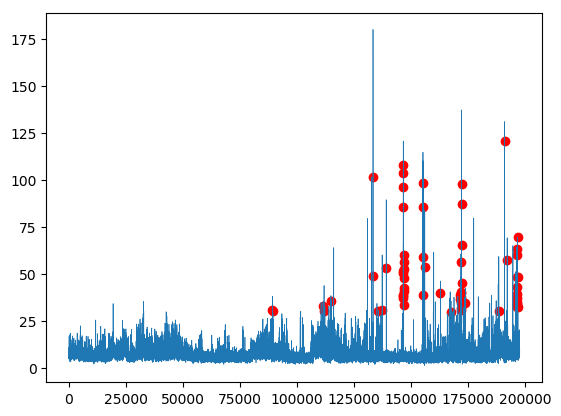

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff785256908>

In [135]:
distances = map(i -> distance(path[i], path[i+1]), 1:length(path)-1)
for x in 10:10:length(path)-1
    if distances[x] > 30
        scatter(x, distances[x], c="red")
    end
end
plot(distances, lw=0.5)

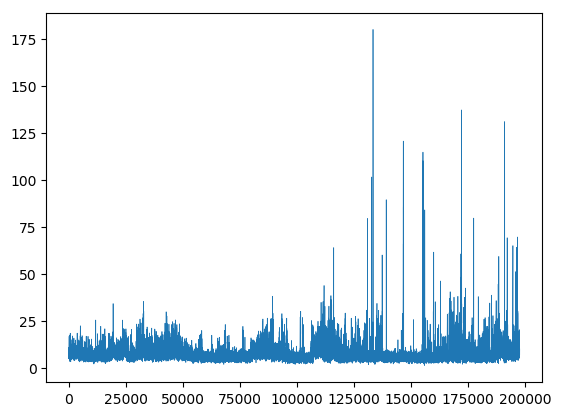

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff7b5c36940>

In [60]:
distances = map(i -> distance(path[i], path[i+1]), 1:length(path)-1)
plot(distances, lw=0.5)

In [65]:
using Statistics

In [67]:
mean(distances)

7.60283859354762

In [72]:
sum(distances[distances .> 100])

3184.7072272934884

In [73]:
sum(distances .> 100)

27

In [51]:
123%10

3

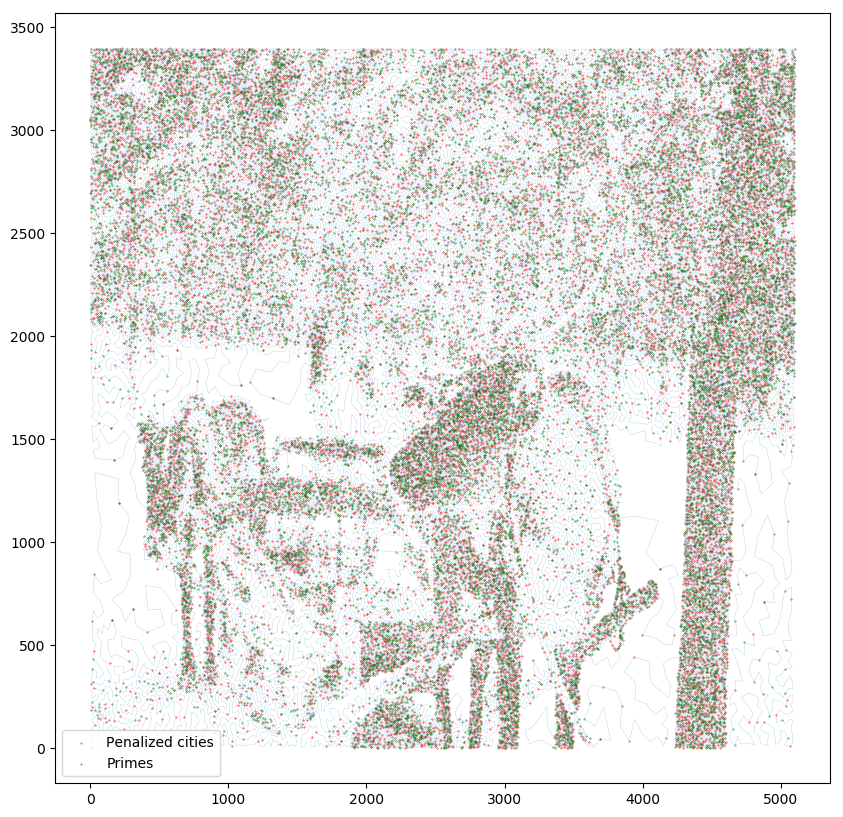

In [74]:
penalized = path[10:10:length(cities)]
primes = filter(c -> c.p, path)
figure(figsize=(10,10))
plot(map(c -> c.x, path), map(c -> c.y, path), lw=0.1)
scatter(map(c -> c.x, penalized), map(c -> c.y, penalized), c="red", s=0.1, label="Penalized cities")
scatter(map(c -> c.x, primes), map(c -> c.y, primes), c="green", s=0.1, label="Primes")
legend()
# savefig("santa2_hd.png", transparent=false, dpi=600, bbox_inches="tight")

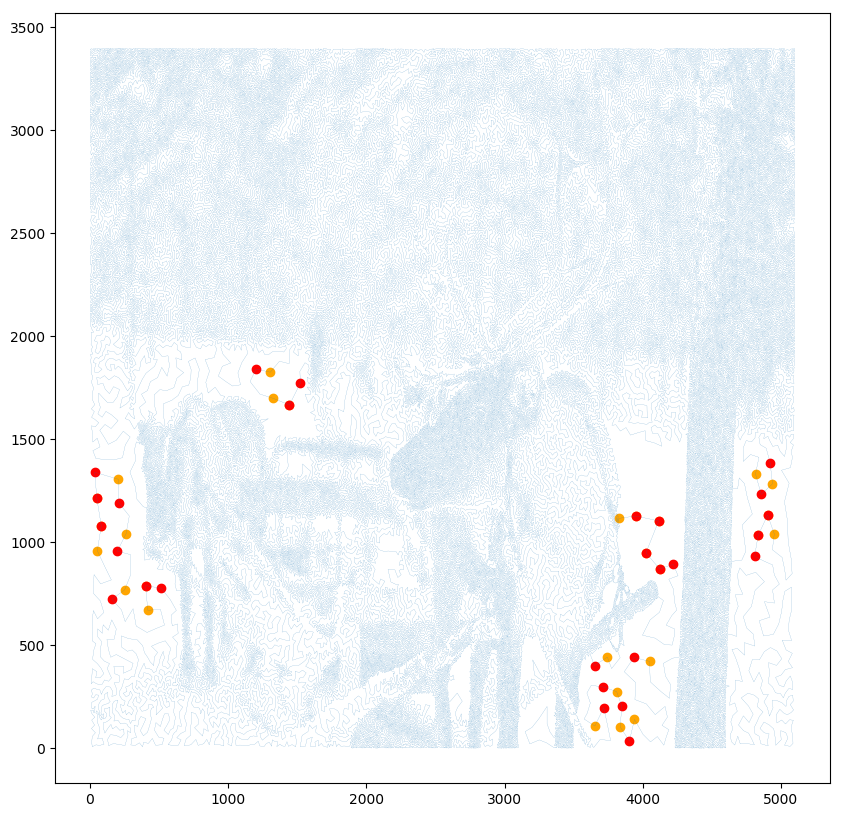

In [88]:
figure(figsize=(10,10))
plot(map(c -> c.x, path), map(c -> c.y, path), lw=0.1)
for c in path[findall(distances .> 100)]
    scatter(c.x, c.y, c="orange", label="start")
end
for c in path[findall(distances .> 100).+1]
    scatter(c.x, c.y, c="red", label="end")
end
savefig("santa3.png", transparent=false, dpi=600, bbox_inches="tight")

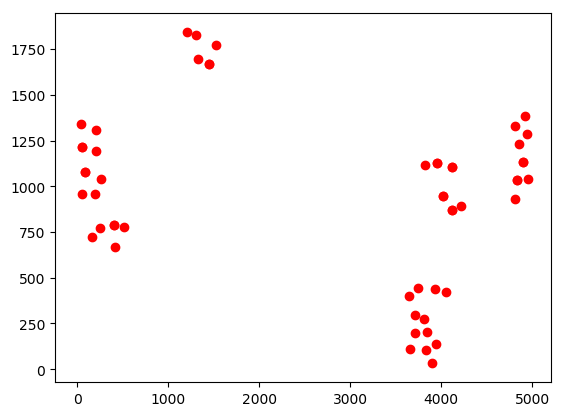

In [5]:
path[10:10:length(cities)]

19776-element Array{City,1}:
 City(22880, false, 323.541435012613, 2172.48684781406) 
 City(148033, false, 318.224743939734, 2146.58073756244)
 City(81072, false, 298.766447758674, 2175.7408433968)  
 City(171066, false, 310.83613414281, 2137.6790798072)  
 City(167893, false, 341.391315721585, 2169.28400855022)
 City(146017, false, 359.782109605941, 2158.67961733869)
 City(97354, false, 371.804976208308, 2154.56269444775) 
 City(36134, false, 363.498351721359, 2126.9943772519)  
 City(165087, false, 337.681607412132, 2142.82727674789)
 City(119148, false, 331.632630517007, 2130.1644888624) 
 City(114594, false, 305.523699478045, 2132.65777609093)
 City(24164, false, 282.259875130207, 2120.98063443527) 
 City(2112, false, 295.776091757977, 2137.23458636173)  
 ⋮                                                      
 City(189408, false, 528.943140531705, 2301.2928313789) 
 City(10386, false, 519.184896624269, 2296.530525687)   
 City(73336, false, 476.882309393943, 2260.8457692778)  
 C

In [45]:
@views function Santa.score(path::Vector{City})
    @assert path[1].i == path[end].i == 0
    dist = 0.0
    penalties = 0.0
    @inbounds for i in 1:length(path)-1
        if (i % 10 == 0) && !path[i].p
            d = distance(path[i], path[i+1])
            dist += d*1.1
            penalties += d*0.1
        else
            dist += distance(path[i], path[i+1])
        end
    end
    dist, penalties
end

d, p = score(path)

(1.5169178997302188e6, 13556.08529108912)

In [48]:
@benchmark score(path)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     431.957 μs (0.00% GC)
  median time:      461.687 μs (0.00% GC)
  mean time:        476.052 μs (0.00% GC)
  maximum time:     1.865 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [75]:
d-p

1.5033618144391298e6

In [73]:
sum(c -> c.p, path[10:10:length(cities)])

1879

In [9]:
length(10:10:length(cities))

19776

In [70]:
path = read_path(cities, "/home/maxmouchet/Downloads/1516917.csv");
score(path)

(1.5169178997302188e6, 13556.08529108912)

In [72]:
best, _ = score(path)
@showprogress for i in 2:length(path)-1
    if (i % 10 == 0) && !cities[i].p
        bv, bk = best, 0
        for k in -2:2
            if cities[i+k].p
                reverse!(path, min(i,i+k), max(i,i+k))
                #path[i], path[i+k] = path[i+k], path[i]
                s, _ = score(path)
                if s < bv
                    bv, bk = s, k
                end
                reverse!(path,  min(i,i+k), max(i,i+k))
                # path[i], path[i+k] = path[i+k], path[i]
            end
        end
        if bk != 0
            reverse!(path,  min(i,i+bk), max(i,i+bk))
        end
        #path[i], path[i+bk] = path[i+bk], path[i]
    end
end
score(path)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


(1.5169178997302188e6, 13556.08529108912)

In [38]:
maximum(10:10:length(cities))+9

197769

In [39]:
length(path)

197770

In [33]:
sum(c -> c.p, path[10:10:length(cities)])

1890

In [18]:
best, _ = score(path)
for i in 2:length(path)-1
    if i % 10 == 0
        for k = 1:3
            if !path[i].p && path[i-k].p
                path[i], path[i-k] = path[i-k], path[i]
                s, _ = score(path)
                if s < best
                    best = s
                else
                    path[i], path[i-k] = path[i-k], path[i]
                end
            end
        end
    end
end
score(path)

(1.5169145193607896e6, 13549.342736805538)